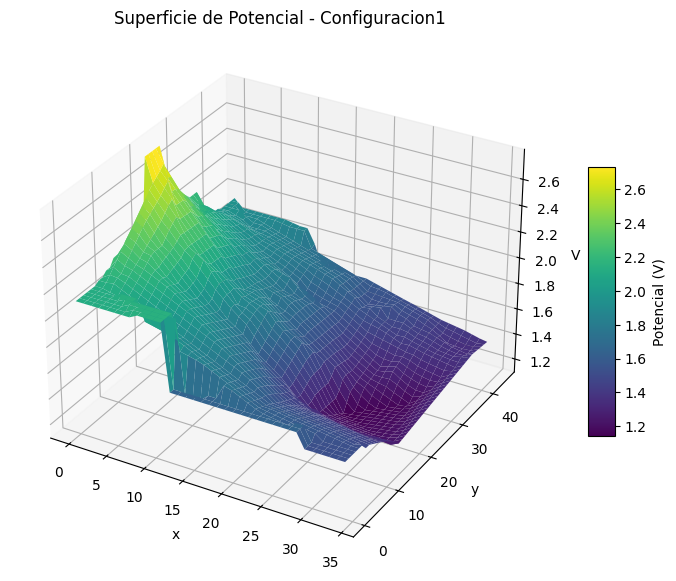

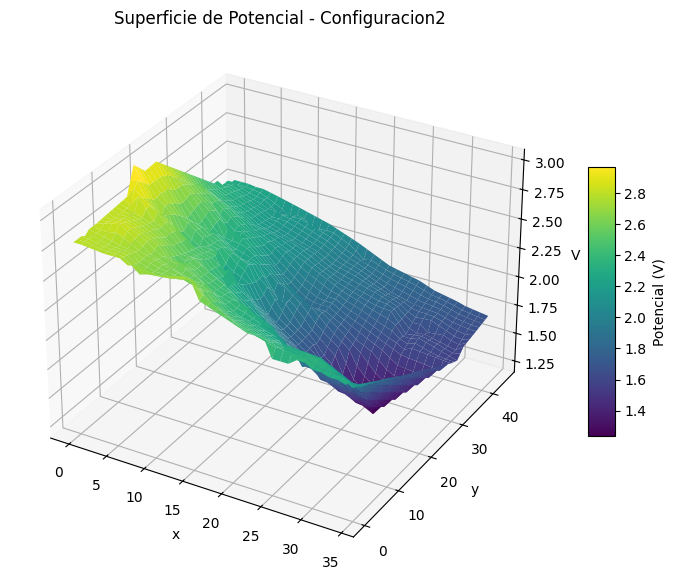

Gráficas generadas y guardadas correctamente.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os

# Ruta base del proyecto
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATOS_DIR = os.path.join(BASE_DIR, "Datos")
GRAFICAS_DIR = os.path.join(os.getcwd(), "Graficas")

# Crear carpeta de gráficas si no existe
os.makedirs(GRAFICAS_DIR, exist_ok=True)

# Archivos de configuración
archivos = ["Configuracion1.xlsx", "Configuracion2.xlsx"]

# Función para cargar datos desde Excel y convertir a matriz numpy
def cargar_datos(nombre_archivo):
    ruta = os.path.join(DATOS_DIR, nombre_archivo)
    df = pd.read_excel(ruta, header=None)
    return df.to_numpy()

# Función para interpolar los ceros en la matriz usando griddata
def completar_zeros(V):
    # Máscara de celdas que son cero (asumimos que son los "datos faltantes")
    mask = V == 0

    # Si no hay ceros, simplemente retornamos la matriz original
    if not np.any(mask):
        return V

    # Obtener las coordenadas (índices) y valores de los puntos conocidos (no ceros)
    puntos_conocidos = np.argwhere(~mask)  # forma: (n_puntos, 2) con [fila, columna]
    valores_conocidos = V[~mask]

    # Obtener las coordenadas de los puntos a interpolar (donde hay ceros)
    puntos_faltantes = np.argwhere(mask)

    # Interpolar los valores faltantes utilizando interpolación lineal
    valores_interpolados = griddata(puntos_conocidos, valores_conocidos, puntos_faltantes, method='linear')

    # En caso de que haya NaN (por estar fuera del casco convexo), usar el método 'nearest'
    if np.any(np.isnan(valores_interpolados)):
        valores_nearest = griddata(puntos_conocidos, valores_conocidos, puntos_faltantes, method='nearest')
        # Reemplazamos los NaN con los valores interpolados por el método nearest
        valores_interpolados[np.isnan(valores_interpolados)] = valores_nearest[np.isnan(valores_interpolados)]

    # Crear una copia de V para rellenar los valores faltantes
    V_completo = V.copy()
    for idx, (i, j) in enumerate(puntos_faltantes):
        V_completo[i, j] = valores_interpolados[idx]

    return V_completo

# Función para graficar equipotenciales (2D) y superficie (3D)
def graficar(V, nombre_base):
    x = np.arange(V.shape[1])
    y = np.arange(V.shape[0])
    X, Y = np.meshgrid(x, y)

    # Gráfica 2D: Equipotenciales
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, V, cmap='viridis')
    plt.colorbar(cp, label="Potencial (V)")
    plt.title(f"Mapa de Equipotenciales - {nombre_base}")
    plt.xlabel("x (índice columna)")
    plt.ylabel("y (índice fila)")
    plt.savefig(os.path.join(GRAFICAS_DIR, f"Equipotenciales_{nombre_base}.png"), dpi=300)
    plt.close()

    # Gráfica 3D: Superficie
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, V, cmap=cm.viridis, edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Potencial (V)")
    ax.set_title(f"Superficie de Potencial - {nombre_base}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("V")
    plt.savefig(os.path.join(GRAFICAS_DIR, f"Superficie_{nombre_base}.png"), dpi=300)
    plt.show()
    plt.close()

# Procesar cada archivo
for archivo in archivos:
    base = os.path.splitext(archivo)[0].replace("ó", "o")  # Limpiar nombre para archivos
    datos = cargar_datos(archivo)
    datos_completos = completar_zeros(datos)
    graficar(datos_completos, base)

print("Gráficas generadas y guardadas correctamente.")
